In [13]:
import numpy as np
from matplotlib import pyplot as plt
elev_file ="test_data/megt90n000fb.img"
dust_file = "test_data/dci_lo_ice_dust_16ppd_shifted.raw"
temp_file = None
# elevation, dust map, temperature, thermal inertia(?) and albedo(?)



In [8]:
def load_elevation(file):
    with open(file,"rb") as f:
        dat = f.read()
        z=np.frombuffer(dat, dtype='>i2').reshape(720*8,1440*8).astype(np.float64)
        
    return z

def load_dci(file):
    with open(file,"rb") as f:
        dat = f.read()
    dci = np.frombuffer(dat,dtype=np.float32).reshape(2880,5760)
    return dci

def load_temp(file):
    temp = None
    return temp


elev = load_elevation(elev_file)
dci = load_dci(dust_file)
temp = load_temp(temp_file)



# apply constraints
acceptable_region = (min_elev<elev)&&(elev<max_elev)&&(min_dci<dci)&&(dci<max_dci)&&(max_temp<temp)&&(temp<min_temp)


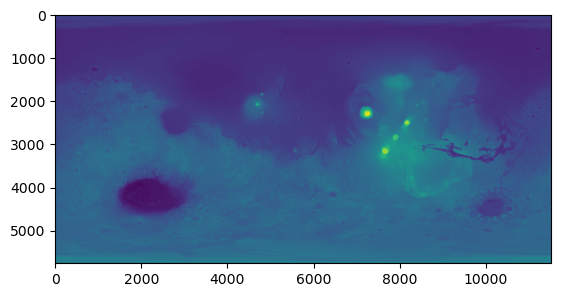

In [11]:
plt.imshow(elev)
plt.imshow(dci)

In [12]:
elev<0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

np.frombuffer(dat).reshape(5760,2880)

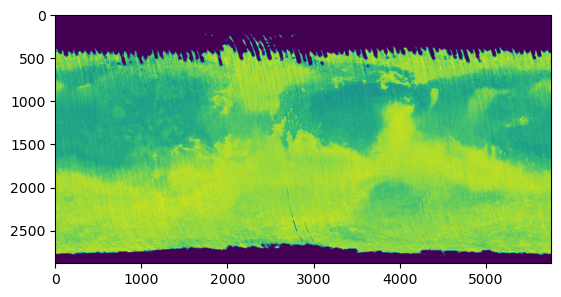

In [43]:
33177600/5760

5760.0